<a href="https://colab.research.google.com/github/supersamk13/Machine-Learning-and-Data-Science/blob/main/Stock_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# pip install yfinance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import joblib
%matplotlib inline

In [ ]:
# Get stocks
stock=input("Enter the code of the stock: ")

Enter the code of the stock: SBUX


In [ ]:
stockdf=yf.download(stock, "2008-01-01", "2023-7-7", auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
for column in stockdf.columns:
  # Handling missing data
  stockdf=stockdf[stockdf[column].notna()]
  # Standardizing
  stockdf[column]=(stockdf[column]-stockdf[column].mean())/stockdf[column].std()
  # Handling outliers
  stockdf=stockdf[(stockdf[column]>-3)&(stockdf[column]<3)]
  # Normalizing
  stockdf[column]=(stockdf[column]-stockdf[column].min())/(stockdf[column].max()-stockdf[column].min())

stockdf=stockdf.reset_index()

In [ ]:
# split date into month, day, and year
def get_date(date):
  day=date.day
  month=date.month
  year=date.year
  return pd.Series(data=(year, month, day), index=['Year', 'Month', 'Day'])

stockdf[['Year','Month','Day']]=stockdf['Date'].apply(get_date)

In [ ]:
stockdf.drop('Date', axis=1, inplace=True)

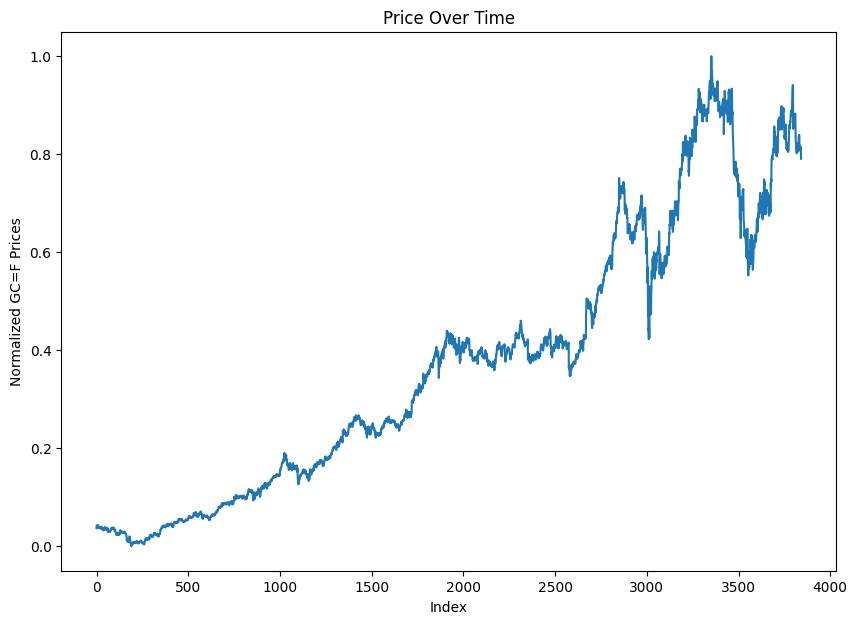

In [ ]:
# Normalize data if it maintains the same shape
stockdf.Close.plot(figsize=(10,7))
plt.ylabel("Normalized GC=F Prices")
plt.xlabel("Index")
plt.title("Price Over Time")
plt.show()

<ipython-input-32-bd65b8faaf27>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(stockdf['Close'])


<Axes: xlabel='Close', ylabel='Density'>

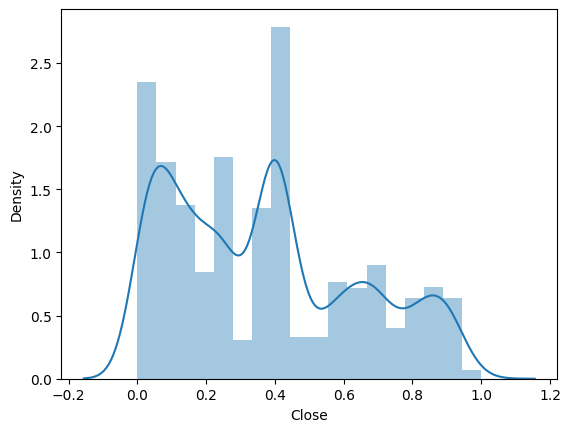

In [ ]:
sns.distplot(stockdf['Close'])

### Conclusions
* Shape of the data
* How our data is distributed
* It's non-linear
* Significant Multicollinearity
* Check Linear, Regularized, SVM

In [ ]:
# Metrics
def calcMetrics(y_test, y_pred):
  print("MSE: ", mean_squared_error(y_test, y_pred))
  print("r2 Score: ", r2_score(y_test, y_pred))

In [ ]:
# Separate data
x=stockdf.drop('Close', axis=1)
y=stockdf['Close']
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.3, random_state=0)

<Axes: >

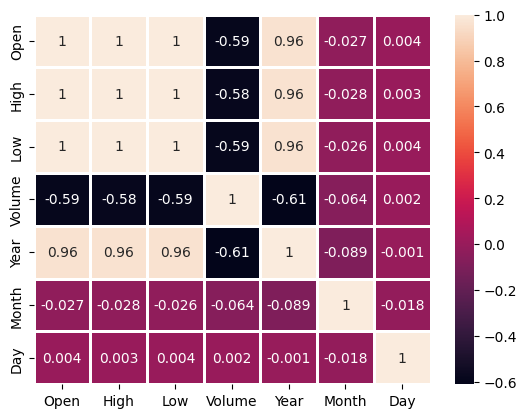

In [ ]:
# Check Multicollinearity
corr=x_train.corr()
sns.heatmap(round(corr,3), annot=True, linewidths=1)

In [ ]:
# Linear Regression
lir=LinearRegression()
lir.fit(x_train, y_train)
lir_pred=lir.predict(x_test)

calcMetrics(y_test, lir_pred)

MSE:  7.72717528080668e-06
r2 Score:  0.9998981251644283


In [ ]:
# Ridge Regression
rr=Ridge()
rr.fit(x_train,y_train)
rr_pred=rr.predict(x_test)

calcMetrics(y_test, rr_pred)

MSE:  2.3039376421643622e-05
r2 Score:  0.9996962495867724


In [ ]:
# Grid Search Ridge Regression
pretune_rr=Ridge()
parameters={'alpha': [0,.0000001]}
tuned_rr=GridSearchCV(estimator=pretune_rr, param_grid=parameters)
tuned_rr.fit(x_train,y_train)
tuned_rr_pred=tuned_rr.predict(x_test)
print(tuned_rr.best_params_)
print(calcMetrics(y_test, tuned_rr_pred))

# Conclusion, optimal alpha value is 0 (same as ordinary linear regression)

{'alpha': 1e-07}
MSE:  7.727188453146567e-06
r2 Score:  0.9998981249907647
None


In [ ]:
# Lasso Regression
lar=Lasso()
lar.fit(x_train, y_train)
lar_pred=lar.predict(x_test)

calcMetrics(y_test, lar_pred)

MSE:  0.060784044080046076
r2 Score:  0.19862507695226728


In [ ]:
# ElasticNet Regression
enr=ElasticNet()
enr.fit(x_train, y_train)
enr_pred=enr.predict(x_test)

calcMetrics(y_test, enr_pred)

MSE:  0.02070785329023887
r2 Score:  0.7269883143165763


In [ ]:
# Support Vector Regression
svr=SVR()

param_grid={'kernel': ['linear'],
            'C': [.010283, .010285, .010287]}

grid_svr=GridSearchCV(SVR(), param_grid, refit=True, verbose=3)

svr.fit(x_train, y_train)
grid_svr.fit(x_train, y_train)

svr_pred=svr.predict(x_test)
grid_svr_pred=grid_svr.predict(x_test)

print(grid_svr.best_params_)

# Default
calcMetrics(y_test, svr_pred)

#Tuned
calcMetrics(y_test, grid_svr_pred)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .........C=0.010283, kernel=linear;, score=0.715 total time=   0.2s
[CV 2/5] END .........C=0.010283, kernel=linear;, score=0.770 total time=   0.2s
[CV 3/5] END .........C=0.010283, kernel=linear;, score=0.788 total time=   0.2s
[CV 4/5] END .........C=0.010283, kernel=linear;, score=0.717 total time=   0.2s
[CV 5/5] END .........C=0.010283, kernel=linear;, score=0.746 total time=   0.2s
[CV 1/5] END .........C=0.010285, kernel=linear;, score=0.717 total time=   0.2s
[CV 2/5] END .........C=0.010285, kernel=linear;, score=0.771 total time=   0.2s
[CV 3/5] END .........C=0.010285, kernel=linear;, score=0.790 total time=   0.2s
[CV 4/5] END .........C=0.010285, kernel=linear;, score=0.725 total time=   0.2s
[CV 5/5] END .........C=0.010285, kernel=linear;, score=0.745 total time=   0.2s
[CV 1/5] END .........C=0.010287, kernel=linear;, score=0.718 total time=   0.2s
[CV 2/5] END .........C=0.010287, kernel=linear;,

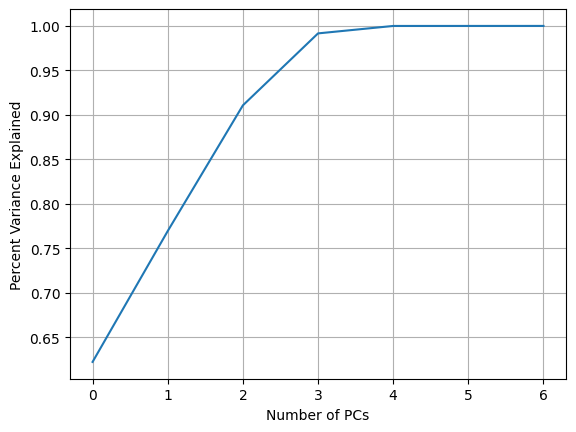

In [ ]:
#PCA

#Standardize x features
std=StandardScaler()
std_x_train=std.fit_transform(x_train)
std_x_test=std.transform(x_test)

pca=PCA(n_components=x_train.shape[1])
pca_data=pca.fit_transform(std_x_train)

percent_explained=pca.explained_variance_/np.sum(pca.explained_variance_)
cumm_sum_explained=np.cumsum(percent_explained)

plt.plot(cumm_sum_explained)
plt.grid()
plt.ylabel("Percent Variance Explained")
plt.xlabel("Number of PCs")
plt.show()

<Axes: >

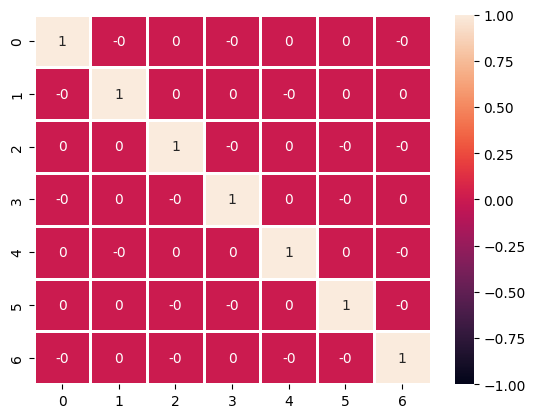

In [ ]:
# Check Post-PCA Multicollinearity
pca_corr=pd.DataFrame(pca_data).corr()
sns.heatmap(round(pca_corr,5), annot=True, vmin=-1, vmax=1, linewidth=1)

In [ ]:
#PCR

pca_train_df=pd.DataFrame(data=std_x_train)
pca_test_df=pd.DataFrame(data=std_x_test)

# Dimensionality Reduction
pca_x_train=pca_train_df.iloc[:,:5]
pca_x_test=pca_test_df.iloc[:,:5]

#Train model and Evaluate Results
pca_lr=LinearRegression()
pca_lr.fit(pca_x_train, y_train)
pca_lr_pred=pca_lr.predict(pca_x_test)
calcMetrics(y_test, pca_lr_pred)

MSE:  7.720110006711543e-06
r2 Score:  0.9998982183127796


In [ ]:
# save models
joblib.dump(lir,'Stock_Predictor.sav')
joblib.dump(pca_lr, 'PCA_Stock_Predictor.sav')

['PCA_Stock_Predictor.sav']

In [ ]:
# To load model
linear_model=joblib.load('Stock_Predictor.sav')
PCA_linear_model=joblib.load('PCA_Stock_Predictor.sav')